In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Importing data from kaggle into joint dataframe df

In [2]:
filenames = ['Accidents0515.csv','Casualties0515.csv','Vehicles0515.csv']
df_Accidents = pd.read_csv(filenames[0],index_col='Accident_Index')
df_Casualties = pd.read_csv(filenames[1], error_bad_lines=False,index_col='Accident_Index',warn_bad_lines=False)
df_Vehicles = pd.read_csv(filenames[2], error_bad_lines=False,index_col='Accident_Index',warn_bad_lines=False)

df = df_Accidents.join(df_Vehicles, how = 'outer')


Data Cleaning

In [3]:
non_essential_columns = ['Location_Easting_OSGR','2nd_Road_Class','2nd_Road_Number','Pedestrian_Crossing-Human_Control','Police_Force','Location_Northing_OSGR','Did_Police_Officer_Attend_Scene_of_Accident','LSOA_of_Accident_Location']
df.drop(axis = 0, columns = non_essential_columns, inplace=True)

df['Date_time'] =  df['Date'] +' '+ df['Time']
df['Date_time'] = pd.to_datetime(df['Date_time'], infer_datetime_format=True)

df["Weather_Conditions"] = df["Weather_Conditions"].abs()

df.dropna(inplace=True)

Correlation Heat Map of Features of df

<AxesSubplot:>

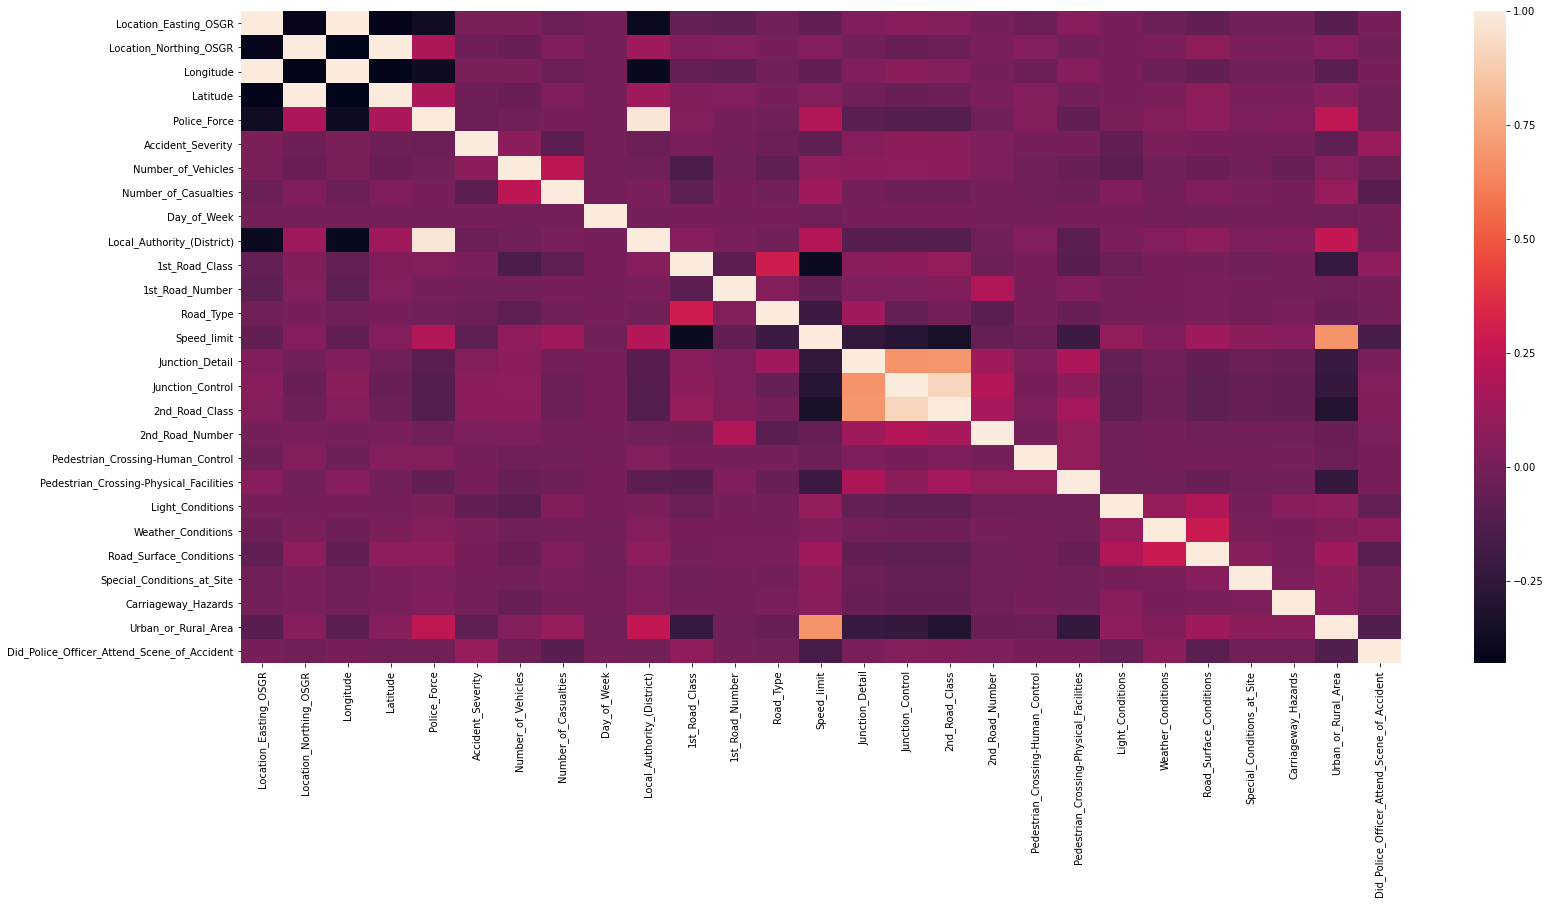

In [4]:
corr =  df_Accidents.corr()
plt.subplots(figsize=(26,12))
sns.heatmap(corr)

Setting up data to plot weather conditions and car accident frequency

In [5]:
df_w = df[['Accident_Severity','Number_of_Casualties','Speed_limit','Weather_Conditions']]

weather_encoding = ['fine','rain','snow','high_winds','rain_high_winds','snow_high_winds','fog','other','unknown']
df["Weather_Conditions"] = df["Weather_Conditions"].abs()
bins = np.linspace(min(df["Weather_Conditions"]), max(df["Weather_Conditions"]), 10)
df['Weather_Conditions_binned'] = pd.cut(df['Weather_Conditions'], bins, labels=weather_encoding, include_lowest=True )

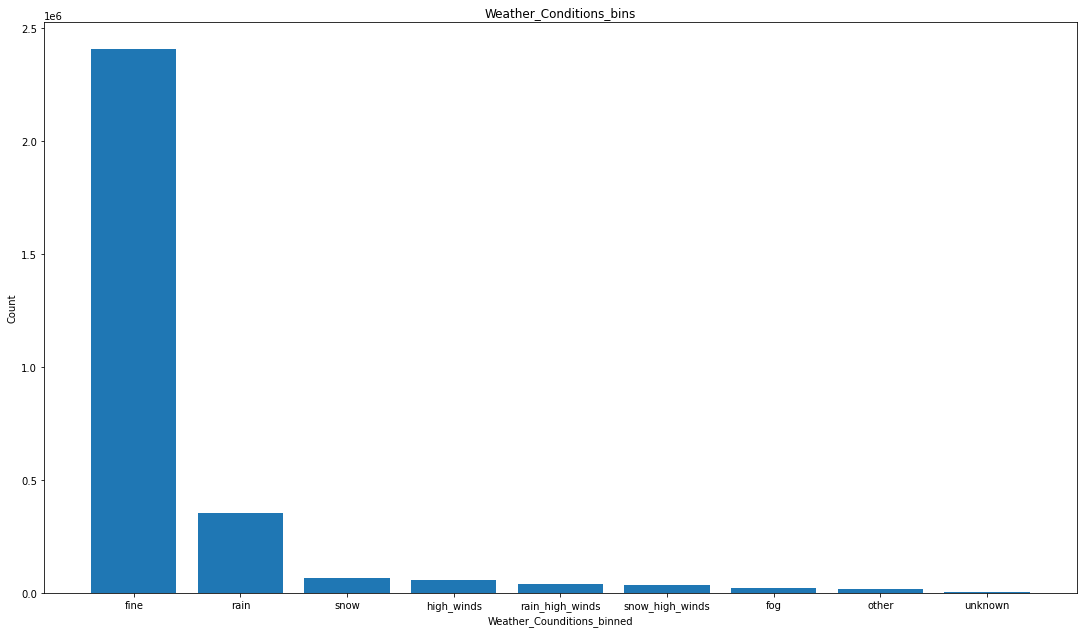

In [6]:
plt.bar(weather_encoding,df['Weather_Conditions_binned'].value_counts())
# set x/y labels and plot title
plt.xlabel("Weather_Counditions_binned")
plt.ylabel("Count")
plt.title("Weather_Conditions_bins")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward = True)

Creating a new dataframe with weather conditions and accident severity frequency

In [7]:
weather_encoding = ['fine','rain','snow','high_winds','rain_high_winds','snow_high_winds','fog','other','unknown']
dct = {}
for i in weather_encoding:
    df_loop = df.loc[df['Weather_Conditions_binned'] == i]
    lst = df_loop['Accident_Severity'].value_counts()
    lstsum = lst.sum()
    lst2 = []
    for i2 in lst:
        lst2.append(i2/lstsum)
    dct.update({i:lst2})
##dct to pandas df
dct_df = pd.DataFrame.from_dict(dct).transpose()
dct_df.rename(columns = {0:'Sleight' , 1:'Serious', 2:'Fatal'},inplace = True)
dct_df
##change values of each column/row to percentage with 0.22 using round(n, 2)
dct_df = dct_df.round(2)
dct_df

,Sleight,Serious,Fatal
fine,0.86,0.13,0.01
rain,0.88,0.11,0.01
snow,0.90,0.09,0.01
high_winds,0.85,0.13,0.02
rain_high_winds,0.87,0.12,0.01
snow_high_winds,0.88,0.12,0.01
fog,0.84,0.14,0.02
other,0.89,0.10,0.01
unknown,0.91,0.08,0.01


Creating a new dataframe with weather conditions and frequency of # of cars in accident

In [8]:
df_veh = df[['Number_of_Vehicles','Weather_Conditions_binned']]
emptylst = list(range(1,11))
df_empty = pd.DataFrame(columns = emptylst, index = weather_encoding)


for i in weather_encoding:
    lst2 = []
    
    dfl = df_veh.loc[df_veh['Weather_Conditions_binned'] == i]
    dfl = dfl['Number_of_Vehicles'].value_counts().to_frame()
    dfl_sum = dfl.sum()
    dfl = dfl/dfl_sum
    dfl = dfl.round(4) * 100
    dfl.sort_index(inplace = True)
    dfl.index.name = 'true'
    dfl_lst = dfl.index.tolist()
    
    for i2 in emptylst:
        if i2 in dfl_lst:
            continue
        else:
            lst2.append(i2)
    dfl = dfl.transpose()
    dfl = dfl.rename(index={'Number_of_Vehicles': i})
    dfl = dfl.iloc[:,0:10]
    df_empty.update(dfl)

df_empty

,1,2,3,4,5,6,7,8,9,10
fine,16.16,65.33,13.07,3.73,1.03,0.38,0.15,0.08,0.04,0.02
rain,17.28,63.25,13.83,3.82,1.01,0.37,0.21,0.08,0.05,0.03
snow,22.59,57.7,13.16,3.73,1.28,0.72,0.2,0.31,0.09,0.1
high_winds,19.49,61.68,13.22,3.81,0.95,0.51,0.13,0.15,0.02,0.03
rain_high_winds,21.73,59.03,13.18,3.78,1.19,0.47,0.22,0.17,0.09,NaN
snow_high_winds,25.89,51.68,12.61,3.69,1.9,1.3,0.95,0.87,0.24,0.54
fog,20.95,54.24,14.98,4.77,1.76,0.84,0.26,0.34,0.16,0.18
other,19.33,63.01,12.51,3.3,0.94,0.33,0.16,0.18,0.11,0.02
unknown,16.8,70.21,9.56,2.43,0.56,0.2,0.06,0.08,NaN,0.04


In [ ]:
Plotting the new dataframe

Text(0, 0.5, 'Frequency (%)')

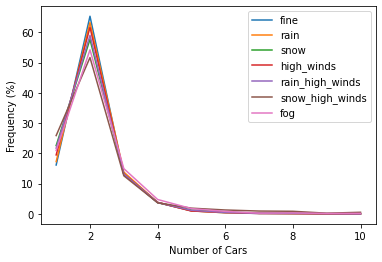

In [9]:
df_empty.replace(np.nan, 0, inplace = True)
df_empty = df_empty.drop(['other','unknown'])
df_empty = df_empty.transpose()


df_empty.plot(kind='line')

plt.xlabel('Number of Cars')
plt.ylabel('Frequency (%)')


Creating a random sample of the data to reduce computing expense during modeling

In [13]:
df_samples = df.sample(frac = 0.10)

Normalizing the data

In [14]:
X = df_samples[['Age_of_Driver','Age_of_Vehicle','Vehicle_Type','Day_of_Week','Weather_Conditions','Road_Surface_Conditions','Light_Conditions','Sex_of_Driver','Speed_limit']]

X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

y = df_samples['Accident_Severity'].values

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Partioning the sample data into train and test sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (240320, 9) (240320,)
Test set: (60080, 9) (60080,)


Training the data using KNN algorithm with values K range 1-10

In [16]:
Ks = 11
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


Plotting the results 

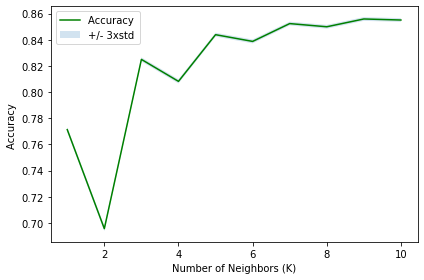

In [17]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.20)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

Training the data on a Decision Tree Classifier with max_depth range from 1 - 10

In [19]:
mean_acc2 = np.zeros((Ks-1))
for n in range(1,Ks):

    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    print(n)
    Tree.fit(X_train,y_train)
    predTree = Tree.predict(X_test)
    mean_acc2[n-1] = metrics.accuracy_score(y_test, yhat)


1
2
3
4
5
6
7
8
9
10


Plotting the results

In [20]:
plt.plot(range(1,Ks),mean_acc2,'g')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

array([0.85510985, 0.85510985, 0.85510985, 0.85510985, 0.85510985,
       0.85510985, 0.85510985, 0.85510985, 0.85510985, 0.85510985])